# OF example

Simulate pulse data, then run OF

Changelog

Oct 22 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
chs = ['PAS1','PBS1'] # channels to use (which also serve as dictionary keys)
names = ['inner','outer']

# general
fsamp = 625000 # Hz
pretrig = 4096 # bins
posttrig = 4096
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4
maxchi2freq = 1e4 # Hz

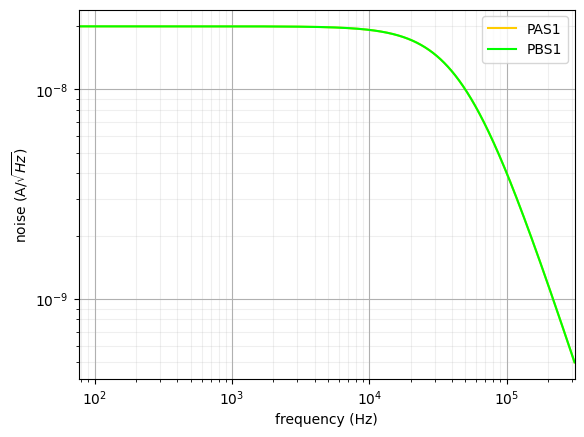

In [3]:
# make PSDs
psdamp = 2e-8
fcut = 5e4
psds = {}
for ch in chs:
    psd = psdamp / (1 + (psdfreq/fcut)**2)
    psds[ch] = psd**2 * (tracelen*fsamp)/2
plotPSDs(psds,tracelen=tracelen)

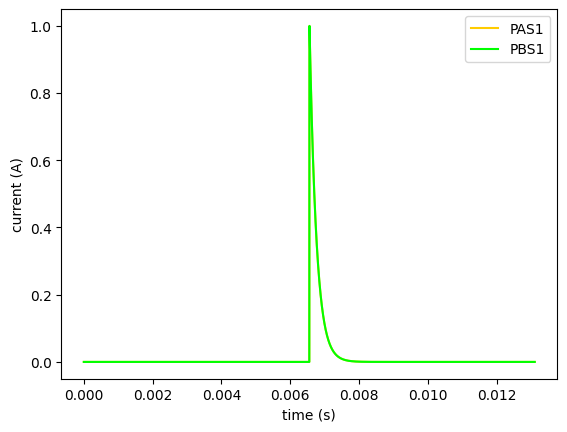

In [4]:
# make pulse templates
templates = {}
t = np.arange(tracelen)/fsamp
ppars = (1e-6,2e-4,pretrig/fsamp) # pulse parameters
for ch in chs:
    templates[ch] = pulse2(t,*ppars)
    
    # plot
    plt.plot(t,templates[ch],color=MIDAScolors[MIDASchs.index(ch)],label=ch)
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [5]:
# simulate data
mu = 1e-5
Ntraces = 1000
#fulltracelen = 32512
fulltracelen = 16000

fullpsdfreq = np.fft.rfftfreq(fulltracelen,1/fsamp)
psd = psdamp / (1 + (fullpsdfreq/fcut)**2)
psd = psd**2 * (fulltracelen*fsamp)/2
norm = np.sqrt(psd/2)
traces = np.zeros((len(chs),Ntraces,fulltracelen))
t = np.arange(fulltracelen)/fsamp

for i in range(Ntraces):
    for j in range(len(chs)):
        rtJ = np.random.normal(0,1,len(fullpsdfreq))*norm*1j
        rtJ += np.random.normal(0,1,len(fullpsdfreq))*norm
        rtJ[0] = 0
        traces[j][i] = mu*pulse2(t,ppars[0],ppars[1],t0=.01)
        traces[j][i] += np.fft.irfft(rtJ)

In [6]:
# instantiate Reduced Quantity object
rq = RQ(data=traces, chs=chs, ch_names=names, detector=1,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=templates,
        maxchi2freq=maxchi2freq)

Using maxchi2freq for lpfs, also


In [7]:
# make OF (for RQs AND triggering) and plot
rq.makeOF()

In [8]:
# trigger options
trigger_mode = 1 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
randomrate = 0 # random triggers to add per trace
trigger_channels = chs # channels to trigger on
trigger_threshold = [mu*0.8,mu*0.8] #[10,10] # in uA
threshold = {}
deactivation_threshold = {}
for i,ch in enumerate(chs):
    threshold[ch] = trigger_threshold[i]
    deactivation_threshold[ch] = 0.5*threshold[ch]

rq.runTrigger(mode=trigger_mode, chs=trigger_channels, randomrate=randomrate,
              threshold=threshold, deactivation_threshold=deactivation_threshold,remove_filter_offset=True)

Removing filter offsets
Triggering on 1000 events
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
939 triggers


Text(0.5, 0, 'time (ms)')

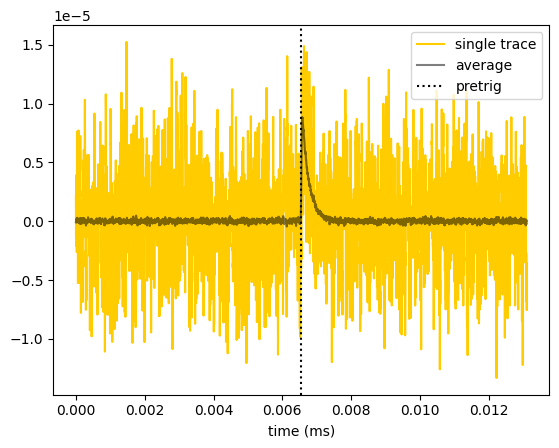

In [9]:
# Plot a trace + average trace - confirm trigger behaves correctly
ch = 'PAS1'
trace=rq.traces[ch][3]
t = np.arange(len(trace))/fsamp
plt.plot(t,trace,color=MIDAScolors[MIDASchs.index(ch)],label='single trace')
plt.plot(t,np.mean(rq.traces['PAS1'],axis=0),'k-',alpha=0.5,label='average')

# the pulse should start at pretrig bin
plt.axvline(pretrig/fsamp,color='k',ls=':',label='pretrig')

plt.legend()
#plt.xlim(0.8*startbin/fsamp,1.4*startbin/fsamp)
plt.xlabel('time (ms)')

In [10]:
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results

Processing PAS1. 939 events
Processing PBS1. 939 events


The optimal filter has been run! Now let's look at some RQs...

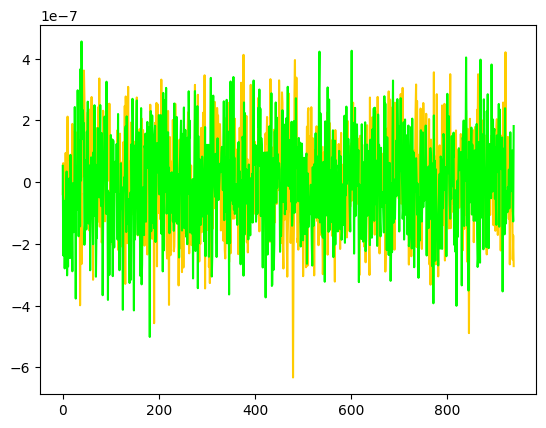

In [11]:
# look at baselines
for ch in chs:
    baselines = RQs[f'MeanBase_{ch}']
    plt.plot(baselines,color=MIDAScolors[MIDASchs.index(ch)])

"\n# could do this manually like so:\nbins=np.linspace(0,mu*2,200)\nfor ch in chs:\n    plt.hist(RQs[f'OF_A_{ch}'],bins=bins,histtype='step',label=ch)\n    plt.legend()\n"

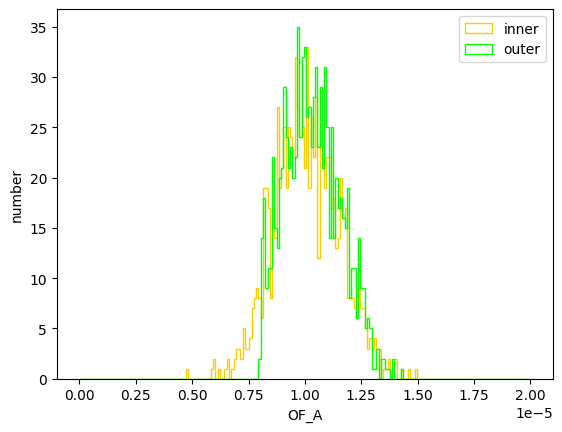

In [12]:
# "spectrum" plot
bins = np.linspace(0,mu*2,200)
for i in range(len(chs)):
    rq.hist1d('OF_A_{0}'.format(chs[i]),bins=bins)

'''
# could do this manually like so:
bins=np.linspace(0,mu*2,200)
for ch in chs:
    plt.hist(RQs[f'OF_A_{ch}'],bins=bins,histtype='step',label=ch)
    plt.legend()
'''

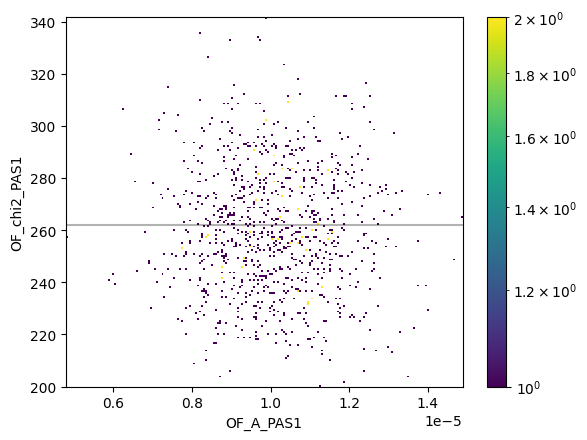

In [13]:
# chi2 vs amplitude plot
ch = chs[0]
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}')

nchi2 = 2*(np.sum(psdfreq<maxchi2freq) - 1)
plt.axhline(nchi2,color='k',alpha=0.3)

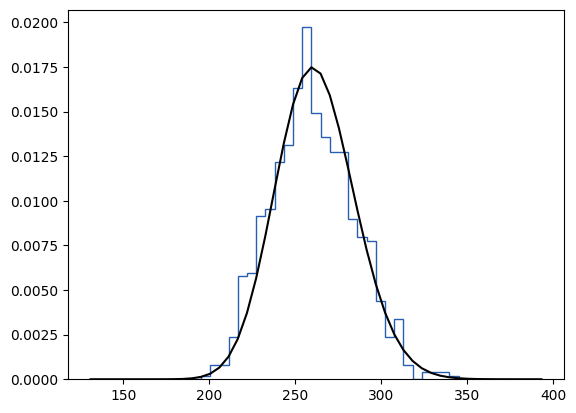

In [14]:
# confirm "chi2" ~ chi2
bins=np.linspace(0.5*nchi2,1.5*nchi2,50)
ch = chs[0]
plt.hist(RQs[f'OF_chi2_{ch}'],bins=bins,histtype='step',density=True)

from scipy.stats import chi2
plt.plot(bins,chi2.pdf(bins,nchi2),'k-')

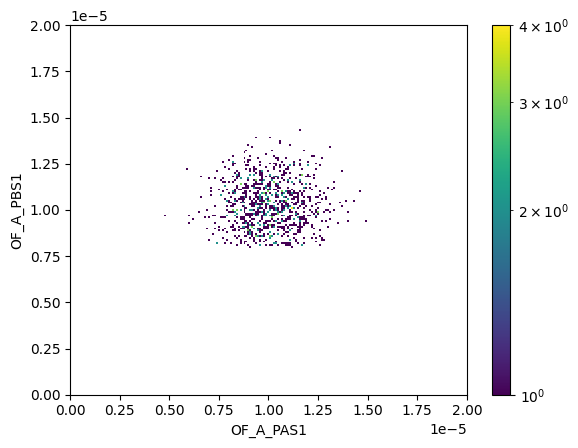

In [15]:
# "partition" plot
ch0,ch1 = chs
bins = (np.linspace(0,2*mu,200),np.linspace(0,2*mu,200))
rq.hist2d(f'OF_A_{ch0}',f'OF_A_{ch1}',bins=bins)
# format

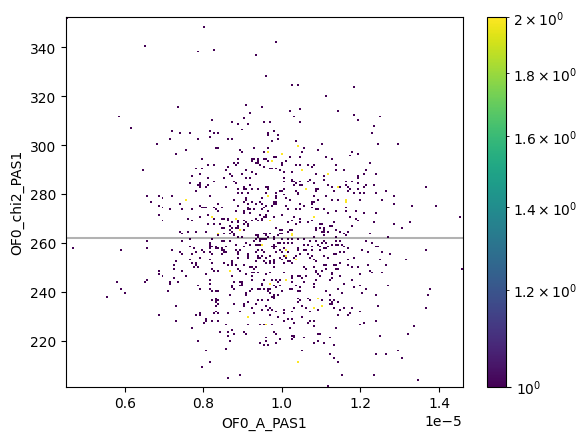

In [16]:
# OF0 working? chi2 vs amplitude plot
ch = chs[0]
rq.hist2d(f'OF0_A_{ch}',f'OF0_chi2_{ch}')

nchi2 = 2*(np.sum(psdfreq<maxchi2freq) - 1)
plt.axhline(nchi2,color='k',alpha=0.3)

In [17]:
# data matches theory?
theores = rq.getTheoryRes()
for ch in chs:
    print(f'{ch} theory: ',theores[ch])
    
    vals = RQs[f'OF_A_{ch}']
    posvals = vals[vals>0]
    print(f'{ch} measure:',np.std(posvals))

PAS1 theory:  1.435129609338082e-06
PAS1 measure: 1.4422787e-06
PBS1 theory:  1.435129609338082e-06
PBS1 measure: 1.2380382e-06
